# Implementing an Advanced Feedforward Neural Network From Scratch

The aim of this project is to code and train an advanced feedforward neural network to predict the ground state energies of molecules given their Coulomb matrices as input. This neural network builds upon the code of the standard feedforward neural network used to train a credit card fraudulent transaction classifier.

The dataset being used is from a research paper that looked at machine learning for this same regression task, and contains ground state energies of 16,242 molecules calculated by quantum mechanical simulations.

The research paper can be found at: https://arxiv.org/pdf/1609.07124.pdf


# Preprocessing the input data
First, we will import the dependencies - **numpy**, the python linear algebra library, **pandas** to load and preprocess the input data and **matplotlib.pyplot** for visualisation purpose. We are using **copy** to make proper copies of dictionaries.. This is useful if we want to save a set of parameters, but want to pass a copy of them to the neural net for further improvement.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

Then we need to load the input data from the csv file:

In [2]:
dataset = pd.read_csv("roboBohr.csv") #create a new dataframe containing the input data
dataset.head() #this outputs the first five rows of the dataset for visualisation purposes

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140


The first preprocessing step is to clean up the input data. The Pubchem_id was included with the dataset to identify the molecule with the given Coulomb Matrix and ground state energy, however is not an input feature so will be removed, as will the first column, which only numbers the molecules from 0 to 16241. 

Following this, we will randomly shuffle the examples to eliminate bias in training/testing. 

Next, we will split the dataframe into the input features *X* (the 1275 entries in the Coulomb matrix) and the expected output *Y* (the ground state energy).
We need to then standardise the input features:
$$X = \frac{X-\mu}{\sqrt{\sigma^2 + \epsilon}}$$ where $\mu$ = mean and $\sqrt{\sigma^2 + \epsilon}$ = standard deviation of each feature ($\epsilon = 10^{-7}$ and is used for numerical stability).
We would also like the dimensions to be a *(num_features) x (num_examples)* matrix for X, and a *1 x (num_examples)* matrix for Y, so we will have to transpose the matrices to achieve this.

In [3]:
#randomly shuffle the data 
dataset = dataset.sample(frac=1).reset_index(drop=True)
#split into X and Y and remove the "Time" feature
X = dataset.iloc[:,1:1276] 
Y = dataset.iloc[:,1277:]

#standardise the input features
X-=X.mean()
X/=np.sqrt(X.std()**2 + 1e-7)

#convert dataframe to a numpy 2D Array (matrix)
X = X.as_matrix()
Y = Y.as_matrix()
X = X.T
Y = Y.T
print("Dimensions of X: " + str(X.shape))
print("Dimensions of Y: " + str(Y.shape))


Dimensions of X: (1275, 16242)
Dimensions of Y: (1, 16242)


Next, since we have randomly shuffled the data, we can split the data into 3 sets - training, cross-validation (dev) and a test set. Since we have 16242 examples, we'll split this in an ~60:20:20 split. This works out to be a 
9746:3248:3248 split. To keep the code clean, we can bundle the 6 matrices in a python dictionary.

In [4]:
TrainTestDevSets = {}

TrainTestDevSets["X_train"] = X[:,:9746]
TrainTestDevSets["Y_train"] = Y[:,:9746]

TrainTestDevSets["X_dev"] = X[:,9746:12994]
TrainTestDevSets["Y_dev"] = Y[:,9746:12994]

TrainTestDevSets["X_test"] = X[:,12994:]
TrainTestDevSets["Y_test"] = Y[:,12994:]

# Creating the neural network:

Having preprocessed our data into matrices, it is now time to create the feedforward neural network. First we will initialise the initial values of our hyperparameters (stored in a python dictionary for tidiness):
The hyperparameters $\alpha$ (learning rate parameter), $\beta_1$ and $\beta_2$ have been set in accordance with the Adam research paper's recommended values.

In [5]:
hyperparameters={}
hyperparameters["num_epochs"] = 10 #number of passes through the training set
hyperparameters["batch_size"] = 128 #number of examples trained upon in each step of training
hyperparameters["layers_units"] = [X.shape[0], 128, 64, 32, 1] #layer 0 is the input layer
hyperparameters["learning_rate"] = 1e-3
hyperparameters["keep_prob"] =0.8 #probability p the neurons will randomly be "blacked out" in dropout implementation 
hyperparameters["beta1"] = 0.9 
hyperparameters["beta2"] = 0.999 #beta1 & beta2 are hyperparameters for the adam optimiser

Now we need to initialise the parameters: the weights for each layer *$ W^{(l)}$*, and the parameters for the batch normalisation of layer *$l$* - $\gamma^{(l)}$ and $\beta^{(l)}$ .
Note: the last layer $L$ is not being batch normalised, so it requires weights $W^{(L)}$ and bias $b^{(L)}$ (a *$n_L$ x $1$* matrix) as parameters 

The weights for layer *$l$* are stored in *$ W^{(l)}$*, a *$n_l$ x $n_{(l-1)}$* matrix, where *$n_l$* is the number of units in layer *$l$*. 
We randomly initialise the weights from a Gaussian distribution ($\mu=0, \sigma =1$) to break symmetry, and multiply these values by 0.001 to achieve quicker convergence.

The parameters $\gamma^{(l)}$ and $\beta^{(l)}$ are real numbers, also initialised from a Gaussian distribution ($\mu=0, \sigma =1$).

NB: the parameter $\beta^{(l)}$ is not linked to the hyperparameters $\beta_1$ and $\beta_2$

In [6]:
def initialise_parameters(layers_units):
    parameters = {}            # create a dictionary containing the parameters
    L = len(layers_units) - 1
    for l in range(1, L ):
        parameters['W' + str(l)] = 0.001* np.random.randn(layers_units[l],layers_units[l-1])
        parameters['gamma' + str(l)] = np.random.randn(layers_units[l],1)
        parameters['beta' + str(l)] = np.random.randn(layers_units[l],1)
    parameters['W' + str(L)] = 0.001* np.random.randn(layers_units[L],layers_units[L-1])
    parameters["b" + str(L)] = np.zeros((layers_units[L],1))
    return parameters

The activation function $g(z)$ we will be using is the ReLU function $g(z) = max(0,z)$ in the hidden layers with no activation function in the final layer, since the task is that of regression. The activation function introduces non-linearities into the overall neural network.

NB: Although the ReLU function is technically non-differentiable when $z=0$, in practice we can set the derivative=0 at $z=0$.

In [7]:
def relu(z, deriv = False):
    if(deriv):
        return z>0
    else:
        return np.multiply(z, z>0)

We can now write the code for the forward propagation step.

In each layer $l$ , we matrix multiply the output of the previous layer $A^{(l-1)}$  by a weight matrix $W^{(l)}$. We then take the result $Z^{(l)}$ and batch normalise it.

Recall that we normalised the input features before training to speed up the optimisation process. The batch normalisation step is the equivalent normalisation step for the unactivated outputs $Z^{(l)}$ of each layer, and also speeds up the optimisation of the weights. The main difference is that rather than normalising the weights with a mean of 0 and variance of 1, the optimal mean and variance of the distribution of the weights can be learnt ($\mu = \beta^{(l)}$ and $\sigma = \gamma^{(l)}$)

We then apply the activation function $g(z)$ to the batch-normalised output to get the output $A^{(l)}$, where $L$ = number of layers. We are also using Dropout - a regularisation technique that randomly "blacks out" neurons in a layer with probability $p$, generating more robust representations, as they are less reliant on a particular neuron or feature. Then, to ensure the expected values of the neurons stay the same, we divide the values of the "active" neurons by $p$.

In the final layer $L$ we  matrix multiply the output of the previous layer $A^{(L-1)}$  by a weight matrix $W^{(L)}$ and add a bias term $b^{(L)}$ to produce a real-valued output (for regression).

The equations are thus:

$$Z^{(l)}=W^{(l)}A^{(l-1)}$$
$$ \mu^{(l)} = \frac{1}{m} \sum_{i = 1}^{m} Z^{(l)(i)}$$ 
$$ \sigma^{2(l)} = \frac{1}{m} \sum_{i = 1}^{m} (Z^{(l)(i)}-\mu)^2$$ 

$$Z^{(l)}_{norm} = \frac{Z^{(l)}-\mu}{\sqrt{\sigma^2 + \epsilon}}$$

$$\widetilde{Z}^{(l)} = \gamma Z^{(l)}_{norm} + \beta$$

$$A^{(l)}=g(\widetilde{Z}^{(l)})$$

$$A^{(l)}= Dropout(A^{(l)})$$ 

$$A^{(l)}= \frac{1}{p}A^{(l)}$$ 
For the final layer: 

$$Z^{(L)}=W^{(L)}A^{(L-1)} + b^{(L)}$$
$$A^{(L)}=Z^{(L)}$$


where $Z^{(l)(i)}$ is the value of $ Z^{(l)}$ for the $i^{th}$ training example, $\epsilon$ = $10^{-7}$ for numerical stability and $m$ = number of examples.



In [8]:
def forward_propagation(X,parameters,keep_prob):
    cache = {}
    L = (len(parameters)+1)//3 #final layer
    cache["A0"] = X #ease of notation since input = layer 0
    m = X.shape[1]
    for l in range(1, L):
        cache['Z' + str(l)] = np.dot(parameters['W' + str(l)],cache['A' + str(l-1)])
        #batch normalisation
        cache["mean" + str(l)] = np.mean(cache['Z' + str(l)], axis=1, keepdims = True)
        cache["variance" + str(l)] = np.var(cache['Z' + str(l)],axis=1, keepdims = True)
        cache['Znorm' + str(l)] = (cache['Z' + str(l)] - cache['mean' + str(l)])/np.sqrt(cache["variance" + str(l)]+1e-7)
        cache["Ztilde" + str(l)] = np.multiply(parameters["gamma" + str(l)],cache['Znorm' + str(l)]) + parameters["beta" + str(l)]
        cache['A' + str(l)] = relu(cache['Z' + str(l)])
        #dropout
        cache["dropout"+ str(l)] = np.random.rand(*cache['A' + str(l)].shape) <= keep_prob
        cache['A' + str(l)] = np.multiply(cache['A' + str(l)], cache["dropout"+ str(l)])
        cache['A' + str(l)]/= keep_prob
        
    #final layer
    cache['Z' + str(L)] = np.dot(parameters['W' + str(L)],cache['A' + str(L-1)]) + parameters['b' + str(L)]
    cache["A" + str(L)] = cache["Z" + str(L)]

    return cache 

Next we can compute the cost function - this is the objective function the neural network will aim to minimise during training:

We are using the Mean Squared Error cost function as this is a regression task.

$m$ = number of training examples, $(x^{(i)},y^{(i)})$ is the $i^{th}$ training example.
$$J(W^{(1)}, b^{(1)},...) = \frac{1}{m} \sum\limits_{i = 1}^{m}(A^{((L)(i)} - y^{(i)})^2$$



In [3]:
def cost_function(AL,Y):
    m = Y.shape[1]
    cost = (1/m)*(np.sum(np.square(AL - Y)))
    return cost

Now we will code the backpropagation algorithm. This will enable us to calculate the partial derivative of the cost function with respect to each of the weights, $\gamma^{(l)}$s and $\beta^{(l)}$s  in each of the layers of the network.

The equations can be derived using the multivariable chain rule and are as follows: 

For the last layer:
$$\frac{\partial \mathcal{J} }{\partial Z^{(L)}} = 2(A^{(L)} - Y)$$ 

$$ \frac{\partial \mathcal{J} }{\partial W^{(L)}} = \frac{1}{m}\frac{\partial \mathcal{J} }{\partial Z^{(L)}} A^{(L-1) T} $$


$$ \frac{\partial \mathcal{J} }{\partial b^{(L)}} = \frac{1}{m} \sum_{i = 1}^{m} \frac{\partial \mathcal{J} }{\partial Z^{(L)(i)}}$$

For the previous layers:

Note that we have to "black out" (route zero gradient through) the same neurons that were "blacked out" in the forward propagation step, and divide by $p$ to get the same expected value of the partial derivative

$$ \frac{\partial \mathcal{J} }{\partial A^{(l)}} = \frac{1}{p}Dropout ( W^{(l+1) T} \frac{\partial \mathcal{J} }{\partial Z^{(l+1)}})$$

$$ \frac{\partial \mathcal{J} }{\partial \widetilde{Z}^{(l)}} = \frac{\partial \mathcal{J} }{\partial A^{(l)}}*g^{'}(\widetilde{Z}^{(l)})$$

$$ \frac{\partial \mathcal{J} }{\partial Z^{(l)}_{norm}} = \gamma^{(l)}\frac{\partial \mathcal{J} }{\partial \widetilde{Z}^{(l)}}$$

$$ \frac{\partial \mathcal{J} }{\partial \sigma^{2(l)}} = \sum_{i = 1}^{m}(\frac{\partial \mathcal{J} }{\partial Z^{(l)(i)}_{norm}}*({Z}^{(l)(i)}-\mu^{(l)})) * \frac{-1}{2}(\sigma^2 + \epsilon)^{\frac{-3}{2}}$$ 

$$ \frac{\partial \mathcal{J} }{\partial \mu^{(l)}} = \frac{-1}{\sqrt{\sigma^2+\epsilon}}\sum_{i = 1}^{m}\frac{\partial \mathcal{J} }{\partial Z^{(l)(i)}_{norm}} + \frac{\partial \mathcal{J} }{\partial \sigma^{2(l)}}*\frac{-2}{m}\sum_{i = 1}^{m}({Z}^{(l)(i)}-\mu^{(l)}) $$

Since $\frac{1}{m}\sum_{i = 1}^{m}({Z}^{(l)(i)}-\mu^{(l)})$=0,

$$ \frac{\partial \mathcal{J} }{\partial \mu^{(l)}} = \frac{-1}{\sqrt{\sigma^2+\epsilon}}\sum_{i = 1}^{m}\frac{\partial \mathcal{J} }{\partial Z^{(l)(i)}_{norm}}$$

$$ \frac{\partial \mathcal{J} }{\partial Z^{(l)}} = \frac{1}{\sqrt{\sigma^2+\epsilon}}\frac{\partial \mathcal{J} }{\partial Z^{(l)}_{norm}} + \frac{\partial \mathcal{J} }{\partial \sigma^{2(l)}}*\frac{2({Z}^{(l)}-\mu^{(l)})}{m} + \frac{1}{m}\frac{\partial \mathcal{J} }{\partial \mu^{(l)}}  $$

$$ \frac{\partial \mathcal{J} }{\partial \gamma^{(l)}} = \sum_{i = 1}^{m}(\frac{\partial \mathcal{J} }{\partial \widetilde{Z}^{(l)(i)}}*Z^{(l)(i)}_{norm})$$

$$ \frac{\partial \mathcal{J} }{\partial \beta^{(l)}} = \frac{1}{m} \sum_{i = 1}^{m}\frac{\partial \mathcal{J} }{\partial \widetilde{Z}^{(l)(i)}}$$


$$ \frac{\partial \mathcal{J} }{\partial W^{(l)}} = \frac{\partial \mathcal{J} }{\partial Z^{(l)}} A^{(l-1) T} $$

$*$ denotes element-wise multiplication, $\epsilon= 10^{-7}$


In [4]:
def backpropagation(cache,Y,parameters,keep_prob):
    L = (len(parameters)+1)//3
    m = Y.shape[1]
    grads = {}
    grads["dZ" + str(L)]= 2*(cache["A" + str(L)] - Y)
    grads["dW" + str(L)]= (1/m)*np.dot(grads["dZ" + str(L)],cache["A" + str(L-1)].T) 
    grads["db" + str(L)]= (1/m)*np.sum(grads["dZ" + str(L)],axis=1,keepdims=True)
    for l in range(L-1,0,-1):
        grads["dA" + str(l)]= np.dot(parameters["W" + str(l+1)].T,grads["dZ" + str(l+1)])
        grads["dA" + str(l)]= (1/keep_prob)*np.multiply(cache["dropout"+str(l)],grads["dA" + str(l)])
        
        #batchnorm backprop - we don't need the variables later so won't store them in grads
        dZtilde= np.multiply(grads["dA" + str(l)], relu(cache["Z" + str(l)], deriv = True))
        dZnorm = np.multiply(parameters["gamma"+ str(l)],dZtilde)
        dvar = np.sum(np.multiply(dZnorm,(cache["Z"+str(l)]-cache["mean"+str(l)])),axis=1,keepdims=True)
        dvar = (-1/2)*np.multiply(dvar,np.power((cache["variance"+str(l)]+1e-7),-1.5))   
        dmean = -1*np.power((cache["variance"+str(l)]+1e-7),-0.5)
        dmean = np.multiply(dmean,np.sum(dZnorm,axis=1,keepdims=True))
        grads["dZ" + str(l)] = np.multiply(np.power((cache["variance"+str(l)]+1e-7),-0.5),dZnorm)
        grads["dZ" + str(l)]+= (2/m)*np.multiply(dvar,(cache["Z" + str(l)]-cache["mean" + str(l)]))
        grads["dZ" + str(l)]+= (1/m)*dmean
        grads["dgamma" + str(l)] = np.sum(np.multiply(dZtilde,cache["Znorm" + str(l)]),axis=1,keepdims = True)
        grads["dbeta" + str(l)] = np.sum(dZtilde,axis=1,keepdims = True)    
        
        grads["dW" + str(l)]= (1/m)*np.dot(grads["dZ" + str(l)],cache["A" + str(l-1)].T) 
    return grads

The evaluation metric will simply be the cost function (the Mean Squared Error) as this is a good metric for a regression task.

Next, we need to code the helper function for the update step. We will be using the Adam optimisation step on minibatches, rather than traditional gradient descent, since Adam is a faster optimiser.

The Adam optimisation equations for variable $x$ w.r.t cost function $J$ are as follows:

Initialise  $v=0, s=0$

*For minibatch t:*
    
  Compute $ \frac{\partial \mathcal{J} }{\partial x}$ using current minibatch
  
  $$ v = \beta_1 v + (1-\beta_1)\frac{\partial \mathcal{J} }{\partial x}$$
  
  $$ s = \beta_2 s + (1-\beta_2)(\frac{\partial \mathcal{J} }{\partial x})^2$$ where $^2$ = element-wise squaring
  
  $$ v_{corrected} = \frac{v}{1-\beta_1^t}$$
  
  $$ s_{corrected} = \frac{s}{1-\beta_2^t}$$
  
  $$ x = x - \alpha\frac{v_{corrected}}{\sqrt{s_{corrected}+\epsilon}}$$
  
  where $\epsilon = 10^{-8}$ (as recommended by the original Adam paper)

In [11]:
def initialise_adam_parameters(parameters):
    L = (len(parameters)+1)//3
    adam_parameters = {}
    for l in range(1,L):
        adam_parameters["vdW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        adam_parameters["sdW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
        
        adam_parameters["vdgamma" + str(l)] = np.zeros_like(parameters["gamma" + str(l)])
        adam_parameters["sdgamma" + str(l)] = np.zeros_like(parameters["gamma" + str(l)])
        
        adam_parameters["vdbeta" + str(l)] = np.zeros_like(parameters["beta" + str(l)])
        adam_parameters["sdbeta" + str(l)] = np.zeros_like(parameters["beta" + str(l)])
        
    adam_parameters["vdW" + str(L)] = np.zeros_like(parameters["W" + str(L)])
    adam_parameters["sdW" + str(L)] = np.zeros_like(parameters["W" + str(L)])
    
    adam_parameters["vdb" + str(L)] = np.zeros_like(parameters["b" + str(L)])
    adam_parameters["sdb" + str(L)] = np.zeros_like(parameters["b" + str(L)])
    
    return adam_parameters

In [12]:
def update_with_adam(parameter, derivative, batch_num, learning_rate, beta1,beta2,v_prev, s_prev):
        v = beta1*v_prev + (1-beta1)*derivative
        s = beta2*s_prev + (1-beta2)*np.square(derivative)
        v_corrected = v/(1-beta1**batch_num)
        s_corrected = s/(1-beta2**batch_num)     
        parameter -= learning_rate*np.divide(v_corrected,np.sqrt(s_corrected + 1e-8))  
        return parameter,v,s  

In [13]:
def update_parameters_with_adam(parameters,adam_parameters,grads,batch_num, learning_rate, beta1,beta2):
    L = (len(parameters)+1)//3
    for l in range(1,L):
        parameters["W" + str(l)],adam_parameters["vdW" + str(l)], adam_parameters["sdW" + str(l)] = update_with_adam(
            parameters["W" + str(l)],grads["dW" + str(l)], batch_num, learning_rate, beta1,beta2,
            adam_parameters["vdW" + str(l)],adam_parameters["sdW" + str(l)])
        
        parameters["gamma" + str(l)],adam_parameters["vdgamma" + str(l)], adam_parameters["sdgamma" + str(l)] = update_with_adam(
            parameters["gamma" + str(l)],grads["dgamma" + str(l)], batch_num, learning_rate, beta1,beta2,
            adam_parameters["vdgamma" + str(l)],adam_parameters["sdgamma" + str(l)])
        
        parameters["beta" + str(l)],adam_parameters["vdbeta" + str(l)], adam_parameters["sdbeta" + str(l)] = update_with_adam(
            parameters["beta" + str(l)],grads["dbeta" + str(l)], batch_num, learning_rate, beta1,beta2,
            adam_parameters["vdbeta" + str(l)],adam_parameters["sdbeta" + str(l)])
        
        
        
    parameters["W" + str(L)],adam_parameters["vdW" + str(L)], adam_parameters["sdW" + str(L)] = update_with_adam(
            parameters["W" + str(L)],grads["dW" + str(L)], batch_num, learning_rate, beta1,beta2,
            adam_parameters["vdW" + str(L)],adam_parameters["sdW" + str(L)])
    
    parameters["b" + str(L)],adam_parameters["vdb" + str(L)], adam_parameters["sdb" + str(L)] = update_with_adam(
            parameters["b" + str(L)],grads["db" + str(L)], batch_num, learning_rate, beta1,beta2,
            adam_parameters["vdb" + str(L)],adam_parameters["sdb" + str(L)])
    
    return parameters, adam_parameters



At test time, the model performs a modified forward propagation step. We do not apply Dropout to the neurons in any layer, and instead of computing the mean $\mu^{(l)}$ and variance $\sigma^{2(l)}$ of the unactivated outputs $Z^{(l)}$ for each layer $l$, we use the expected values of $\mu^{(l)}$ and $\sigma^{2(l)}$.
This can be done by taking an running exponentially weighted average of the $\mu^{(l)}$ and $\sigma^{2(l)}$ during training from the cache of the forward propagation step from each mini-batch of training examples.

In [14]:
def predict(X,parameters,running_stats):
    cache = {}
    L = (len(parameters)+1)//3 #final layer
    cache["A0"] = X #ease of notation since input = layer 0
    m = X.shape[1]
    for l in range(1, L):
        cache['Z' + str(l)] = np.dot(parameters['W' + str(l)],cache['A' + str(l-1)])
        #batch normalisation
        cache["mean" + str(l)] = running_stats["mean" + str(l)]
        cache["variance" + str(l)] = running_stats["variance" + str(l)]
        cache['Znorm' + str(l)] = (cache['Z' + str(l)] - cache['mean' + str(l)])/np.sqrt(cache["variance" + str(l)]+1e-7)
        cache["Ztilde" + str(l)] = np.multiply(parameters["gamma" + str(l)],cache['Znorm' + str(l)]) + parameters["beta" + str(l)]
        cache['A' + str(l)] = relu(cache['Z' + str(l)])
        
    #final layer
    cache['Z' + str(L)] = np.dot(parameters['W' + str(L)],cache['A' + str(L-1)]) + parameters['b' + str(L)]
    AL = cache["Z" + str(L)]

    return AL 

In [37]:
def train_model(X_train, Y_train, X_dev, Y_dev,hyperparameters,parameters):
    train_costs = []
    dev_costs = []
    costs = {}
    num_epochs = hyperparameters["num_epochs"]
    batch_size = hyperparameters["batch_size"]
    layers_units = hyperparameters["layers_units"] 
    learning_rate = hyperparameters["learning_rate"]
    keep_prob = hyperparameters["keep_prob"]
    beta1 = hyperparameters["beta1"]
    beta2 = hyperparameters["beta2"]
    
    running_stats = {} #store the running exponentially weighted average of the mean and variance of each layer
    L = len(layers_units)-1 
        
    for epoch in range (num_epochs):
        
        print("Training the model, epoch: " + str(epoch+1))
        adam_parameters = initialise_adam_parameters(parameters)

        #cycle through the entire training set in batches
        for i in range(0,X_train.shape[1]//batch_size):
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[:,i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights 
            #Calculate the cost - used to monitor training
            minibatch_cache = forward_propagation(X_train_minibatch,parameters,keep_prob)
            minibatch_cost = cost_function(minibatch_cache["A" + str(L)],Y_train_minibatch)
            minibatch_grads = backpropagation(minibatch_cache,Y_train_minibatch,parameters,keep_prob)
            parameters, adam_parameters = update_parameters_with_adam(parameters,adam_parameters,minibatch_grads,i+1, learning_rate, beta1,beta2)    
            
            #update the running exp weighted averages of mean and var in each layer
            if (epoch==0 and i==0):
                for l in range(1,L):
                    running_stats["mean" + str(l)] = minibatch_cache["mean" + str(l)]
                    running_stats["variance" + str(l)] = minibatch_cache["variance" + str(l)]
            else:
                for l in range(1,L):
                    running_stats["mean" + str(l)] = 0.8*running_stats["mean" + str(l)] + 0.2*minibatch_cache["mean" + str(l)]                            
                    running_stats["variance" + str(l)] = 0.8*running_stats["variance" + str(l)] + 0.2*minibatch_cache["variance" + str(l)]
                    
                    
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i%10 == 0):
                train_costs.append(minibatch_cost)
                print("Training cost after iteration " + str(i) + ": " + str(minibatch_cost))
                dev_AL = predict(X_dev,parameters, running_stats)
                dev_cost= cost_function(dev_AL,Y_dev)
                dev_costs.append(dev_cost)
                print("Dev set cost: "+ str(dev_cost))
    print("Training complete!")
    #return the trained parameters and the visualisation metrics
    costs["train"] = train_costs
    costs["dev"] = dev_costs
    return parameters, costs, running_stats

Having trained the model, it is useful to have a sense of how the model trained over time - we can do this by plotting the training set error and the dev set error as training progresses. As an unbiased benchmark for the performance, we also can print the error on the test set.

It is also important to get the error for the model on the training and dev sets to compare relative performance, and see if the model is suffering from high bias (underfitting) or high variance (overfitting). By using only the train and dev set performances to tune the model, we ensure we still have an unbiased benchmark after tuning.


In [32]:
def evaluate_model(train_costs, dev_costs, parameters, running_stats, X_train, Y_train, X_dev, Y_dev, X_test, Y_test):
    #plot the graphs of training set error and dev set F1 score
    plt.plot(np.squeeze(train_costs))
    plt.ylabel('Cost')
    plt.xlabel('10s of Iterations')
    plt.title("Training Set Error")
    plt.show()
    plt.plot(np.squeeze(dev_costs))
    plt.ylabel('Cost')
    plt.xlabel('10s of Iterations')
    plt.title("Dev Set Error")
    plt.show()
    
    L = (len(parameters)+1)//3
    
    #For each of the train, dev and test sets, perform a step of forward propagation to obtain the trained model's 
    #predictions and evaluate this with an F1 score.
    train_AL = predict(X_train,parameters,running_stats)
    print("The train set error is: "+str(cost_function(train_AL,Y_train)))
    
    dev_AL = predict(X_dev,parameters,running_stats)
    print("The dev set error is: "+str(cost_function(dev_AL,Y_dev)))
    
    test_AL = predict(X_test,parameters,running_stats)
    print("The test set error is: "+str(cost_function(test_AL,Y_test)))

We now can write the overall function to run the neural network - this ensures it is easy to run subsequent models by packaging all the functions into one line of code.

In [33]:
def run_model(TrainTestDevSets, hyperparameters,parameters):
    
    X_train = TrainTestDevSets["X_train"] 
    Y_train = TrainTestDevSets["Y_train"]

    X_dev = TrainTestDevSets["X_dev"]
    Y_dev = TrainTestDevSets["Y_dev"] 
    
    X_test = TrainTestDevSets["X_test"] 
    Y_test = TrainTestDevSets["Y_test"]
    
    parameters, costs, running_stats = train_model(X_train, Y_train, X_dev, Y_dev,hyperparameters,parameters)         
    evaluate_model(costs["train"], costs["dev"], parameters,running_stats, X_train, Y_train, X_dev, Y_dev, X_test, Y_test)
    return parameters

Training the model, epoch: 1
Training cost after iteration 0: 141.41374441
Dev set cost: 137.985607898
Training cost after iteration 10: 133.374714114
Dev set cost: 137.742145734
Training cost after iteration 20: 128.651124119
Dev set cost: 137.379318147
Training cost after iteration 30: 129.824515716
Dev set cost: 136.954286807
Training cost after iteration 40: 131.913183136
Dev set cost: 136.582407813
Training cost after iteration 50: 137.815310784
Dev set cost: 135.687685429
Training cost after iteration 60: 138.858498393
Dev set cost: 134.257948881
Training cost after iteration 70: 133.721927864
Dev set cost: 130.48327789
Training the model, epoch: 2
Training cost after iteration 0: 132.939936764
Dev set cost: 128.422533104
Training cost after iteration 10: 125.573425618
Dev set cost: 129.365141088
Training cost after iteration 20: 121.894270865
Dev set cost: 128.726474967
Training cost after iteration 30: 121.526060011
Dev set cost: 126.997314058
Training cost after iteration 40: 

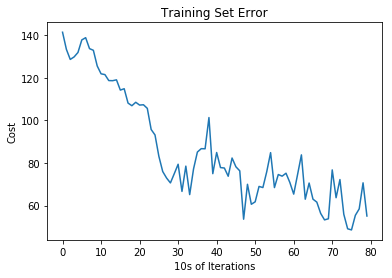

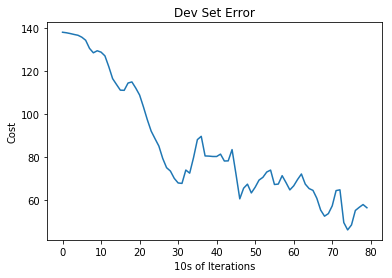

The train set error is: 57.1465294431
The dev set error is: 57.2600640365
The test set error is: 57.3525203942


In [18]:
parameters = run_model(TrainTestDevSets, hyperparameters)

# Improving the model's performance
We can now tune the hyperparameters to improve the model's performance. One key area that needs to be improved is the high bias, since an error of 61.8 in the ground state energy of a molecule is extremely high. This can be reduced by making the model larger and deeper, and training it for longer.

Training the model, epoch: 1
Training cost after iteration 0: 141.413744461
Dev set cost: 137.985611873
Training cost after iteration 10: 133.389203722
Dev set cost: 137.762349751
Training cost after iteration 20: 128.771088923
Dev set cost: 137.540270579
Training cost after iteration 30: 130.122460394
Dev set cost: 137.314147174
Training cost after iteration 40: 132.344693147
Dev set cost: 137.084171607
Training cost after iteration 50: 138.863417154
Dev set cost: 136.852641694
Training cost after iteration 60: 141.028185993
Dev set cost: 136.617821731
Training cost after iteration 70: 139.76544562
Dev set cost: 136.38444492
Training the model, epoch: 2
Training cost after iteration 0: 139.661586518
Dev set cost: 136.244121237
Training cost after iteration 10: 131.650846373
Dev set cost: 135.98514401
Training cost after iteration 20: 127.032446781
Dev set cost: 135.710291943
Training cost after iteration 30: 128.291190454
Dev set cost: 135.392843868
Training cost after iteration 40: 1

Dev set cost: 116.617589413
Training the model, epoch: 14
Training cost after iteration 0: 118.915106379
Dev set cost: 116.78546953
Training cost after iteration 10: 112.220824383
Dev set cost: 116.602279922
Training cost after iteration 20: 108.095015844
Dev set cost: 116.507479777
Training cost after iteration 30: 109.177497214
Dev set cost: 116.244461615
Training cost after iteration 40: 111.054980311
Dev set cost: 116.013451126
Training cost after iteration 50: 116.885004147
Dev set cost: 115.825506561
Training cost after iteration 60: 119.179203266
Dev set cost: 115.470749555
Training cost after iteration 70: 117.743590717
Dev set cost: 115.223351572
Training the model, epoch: 15
Training cost after iteration 0: 117.548664132
Dev set cost: 115.157769823
Training cost after iteration 10: 109.51137212
Dev set cost: 114.374432482
Training cost after iteration 20: 106.27298385
Dev set cost: 114.941558032
Training cost after iteration 30: 107.081041979
Dev set cost: 113.870239136
Train

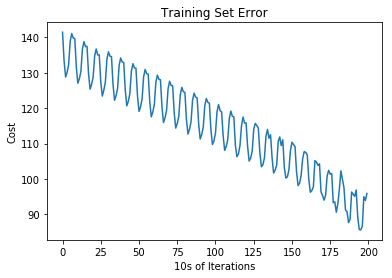

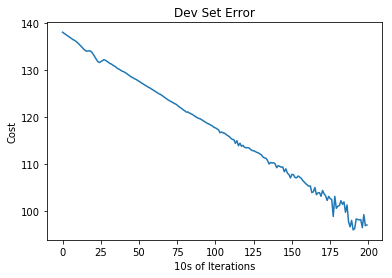

The train set error is: 94.6786282443
The dev set error is: 94.4900014028
The test set error is: 95.5722209321


In [19]:
hyperparameters["layers_units"] = [X.shape[0], 1024, 1024, 1024, 512, 512, 512, 256, 128, 64, 32, 1] 
hyperparameters["num_epochs"] = 25
parameters = run_model(TrainTestDevSets, hyperparameters)

The main issue here is that although the model's error is decreasing during training, it is learning much slower than the initial, much shallower, model. We could increase the learning rate to ameliorate this:

Training the model, epoch: 1
Training cost after iteration 0: 141.413744461
Dev set cost: 137.940924546
Training cost after iteration 10: 132.669666333
Dev set cost: 136.738589218
Training cost after iteration 20: 118.731576803
Dev set cost: 122.513227306
Training cost after iteration 30: 88.9711343775
Dev set cost: 86.9768803784
Training cost after iteration 40: 53.9930368663
Dev set cost: 78.3973052588
Training cost after iteration 50: 65.1654212725
Dev set cost: 80.8391557167
Training cost after iteration 60: 78.2166886912
Dev set cost: 73.4498420944
Training cost after iteration 70: 69.4643554283
Dev set cost: 74.0031715871
Training the model, epoch: 2
Training cost after iteration 0: 72.7005669768
Dev set cost: 73.4451170656
Training cost after iteration 10: 81.121417439
Dev set cost: 72.8275292202
Training cost after iteration 20: 57.9599211334
Dev set cost: 73.5705910542
Training cost after iteration 30: 48.588255471
Dev set cost: 74.6735875742
Training cost after iteration 40: 

Dev set cost: 46.2315184012
Training the model, epoch: 14
Training cost after iteration 0: 47.4192499159
Dev set cost: 43.128317972
Training cost after iteration 10: 44.0306566433
Dev set cost: 43.6826411648
Training cost after iteration 20: 36.4638071157
Dev set cost: 42.0827740024
Training cost after iteration 30: 43.2687385843
Dev set cost: 44.1850298792
Training cost after iteration 40: 43.6164998958
Dev set cost: 45.5321977903
Training cost after iteration 50: 42.9897448013
Dev set cost: 42.960496504
Training cost after iteration 60: 65.2445660611
Dev set cost: 40.9010966471
Training cost after iteration 70: 51.5870338054
Dev set cost: 55.1964577893
Training the model, epoch: 15
Training cost after iteration 0: 49.14845596
Dev set cost: 41.3940625266
Training cost after iteration 10: 38.5075072661
Dev set cost: 42.6444168342
Training cost after iteration 20: 36.6671336256
Dev set cost: 40.6435184987
Training cost after iteration 30: 37.0561051861
Dev set cost: 40.5585411786
Traini

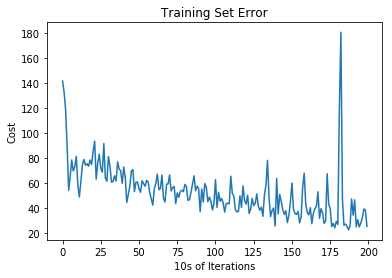

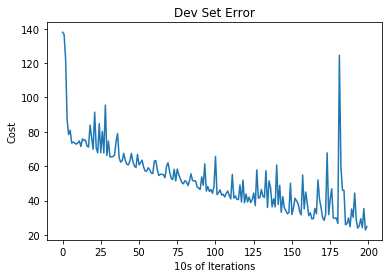

The train set error is: 26.6644112936
The dev set error is: 26.550646482
The test set error is: 26.9510304884


In [20]:
hyperparameters['learning_rate'] = 3e-3
parameters = run_model(TrainTestDevSets, hyperparameters)

The increased learning rate seems to have caused the loss to decrease substantially in the same training time, with only slightly more noise aside from the anomalous peak just after 1750 iterations. It is worth increases the learning rate further to see what the optimal learning rate is.

Training the model, epoch: 1
Training cost after iteration 0: 141.413744461
Dev set cost: 137.784581903
Training cost after iteration 10: 113163.743303
Dev set cost: 722614.224928
Training cost after iteration 20: 759469.888824
Dev set cost: 39765761.7976
Training cost after iteration 30: 86146758.4731
Dev set cost: 72437096.895
Training cost after iteration 40: 149866096.25
Dev set cost: 193899999.627
Training cost after iteration 50: 89272148.1332
Dev set cost: 10917090.2221
Training cost after iteration 60: 77037230.4137
Dev set cost: 83609197.0651
Training cost after iteration 70: 223211487.544
Dev set cost: 10844.8474093
Training the model, epoch: 2
Training cost after iteration 0: 16172230.2857
Dev set cost: 6091235818.94
Training cost after iteration 10: 202977122.268
Dev set cost: 215593715.9
Training cost after iteration 20: 1322635651.73
Dev set cost: 5049356347.09
Training cost after iteration 30: 163666093.982
Dev set cost: 569162955.607
Training cost after iteration 40: 33

Dev set cost: 1026812604.6
Training the model, epoch: 14
Training cost after iteration 0: 718078042.415
Dev set cost: 376513502662.0
Training cost after iteration 10: 175376940651.0
Dev set cost: 55971242392.7
Training cost after iteration 20: 562500725.973
Dev set cost: 24208966845.8
Training cost after iteration 30: 18506328851.9
Dev set cost: 39443218900.2
Training cost after iteration 40: 6769772160.44
Dev set cost: 25087283090.2
Training cost after iteration 50: 8902476334.67
Dev set cost: 698527350.325
Training cost after iteration 60: 21362058632.3
Dev set cost: 13670918454.0
Training cost after iteration 70: 2338846788.51
Dev set cost: 6529264026.16
Training the model, epoch: 15
Training cost after iteration 0: 1595245199.01
Dev set cost: 332679746104.0
Training cost after iteration 10: 46878568244.0
Dev set cost: 580082944.468
Training cost after iteration 20: 16203039399.5
Dev set cost: 20843762408.8
Training cost after iteration 30: 3825198544.6
Dev set cost: 4804820398.13
T

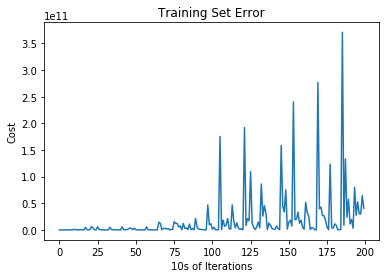

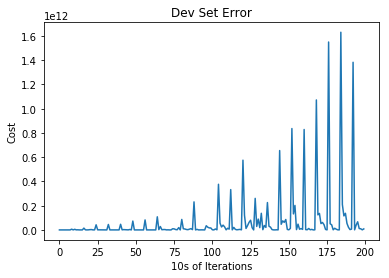

The train set error is: 14603790146.5
The dev set error is: 14927521447.0
The test set error is: 14812668169.6


In [21]:
hyperparameters['learning_rate'] = 1e-2
parameters = run_model(TrainTestDevSets, hyperparameters)


As both the training and dev set graphs show, the model is actually diverging from the optimum, which indicates that the learning rate is too high, and that $\alpha=3*10^{-3}$ is the optimal learning rate. So instead of increasing the learning rate, we can increase number of epochs the model trains for.
To reduce the spikes in learning, we can also increase the batch_size, so the partial derivatives computed from the mini-batches are more likely to be towards the optimum.

Training the model, epoch: 1
Training cost after iteration 0: 140.986491967
Dev set cost: 137.940924546
Training cost after iteration 10: 132.618453023
Dev set cost: 135.544410897
Training the model, epoch: 2
Training cost after iteration 0: 111.922373144
Dev set cost: 106.535255398
Training cost after iteration 10: 81.327607067
Dev set cost: 82.9369587733
Training the model, epoch: 3
Training cost after iteration 0: 82.5308443423
Dev set cost: 74.7446812354
Training cost after iteration 10: 79.1294669281
Dev set cost: 73.0318522938
Training the model, epoch: 4
Training cost after iteration 0: 76.1261496728
Dev set cost: 71.9485220346
Training cost after iteration 10: 66.8052255286
Dev set cost: 72.8213337201
Training the model, epoch: 5
Training cost after iteration 0: 71.5345934499
Dev set cost: 70.96515673
Training cost after iteration 10: 72.2003083147
Dev set cost: 70.6198396818
Training the model, epoch: 6
Training cost after iteration 0: 79.3312922771
Dev set cost: 70.7550196195

Training cost after iteration 10: 52.5190784302
Dev set cost: 48.147246659
Training the model, epoch: 47
Training cost after iteration 0: 55.7281197886
Dev set cost: 49.090103812
Training cost after iteration 10: 50.5610601357
Dev set cost: 50.2506878421
Training the model, epoch: 48
Training cost after iteration 0: 54.4357039376
Dev set cost: 51.9262535257
Training cost after iteration 10: 47.5396382108
Dev set cost: 51.8178707373
Training the model, epoch: 49
Training cost after iteration 0: 53.3094048347
Dev set cost: 50.6809605807
Training cost after iteration 10: 53.5411891055
Dev set cost: 52.141939676
Training the model, epoch: 50
Training cost after iteration 0: 52.5748896442
Dev set cost: 47.7000870636
Training cost after iteration 10: 45.7516311047
Dev set cost: 48.3173989248
Training complete!


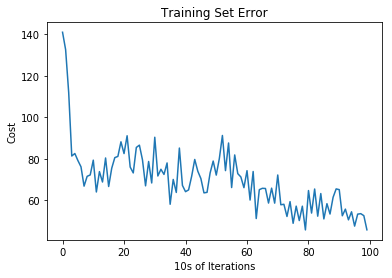

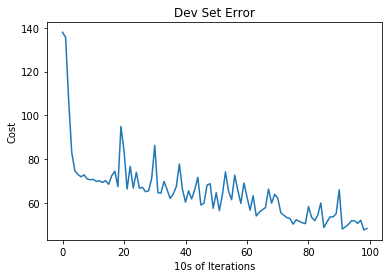

The train set error is: 41.9510740091
The dev set error is: 42.4783535663
The test set error is: 42.0293715131


In [23]:
hyperparameters['learning_rate'] = 3e-3
hyperparameters["batch_size"] = 512
hyperparameters["num_epochs"] = 50
parameters = run_model(TrainTestDevSets, hyperparameters)



The train and dev set errors seem to be decreasing but it seems to be slightly leveling at an error of ~42, which is some distance off the ~26 error achieved earlier. One solution could be to increase the number of hidden units in the layers, as this could be a bottleneck in the learning.

Training the model, epoch: 1
Training cost after iteration 0: 140.986491967
Dev set cost: 137.940924546
Training cost after iteration 10: 76.9950797506
Dev set cost: 80.5516044692
Training the model, epoch: 2
Training cost after iteration 0: 71.0659651993
Dev set cost: 176.136921896
Training cost after iteration 10: 97.720956397
Dev set cost: 85.0094169276
Training the model, epoch: 3
Training cost after iteration 0: 93.5632042986
Dev set cost: 136.520602644
Training cost after iteration 10: 80.0890456115
Dev set cost: 95.002603679
Training the model, epoch: 4
Training cost after iteration 0: 77.9539295601
Dev set cost: 89.3809999173
Training cost after iteration 10: 79.1071375625
Dev set cost: 85.2910170395
Training the model, epoch: 5
Training cost after iteration 0: 84.4818972008
Dev set cost: 170.069675187
Training cost after iteration 10: 65.5141681757
Dev set cost: 92.1723076188
Training the model, epoch: 6
Training cost after iteration 0: 90.7586570785
Dev set cost: 195.98841008

Training cost after iteration 10: 80.84316481
Dev set cost: 88.8887982371
Training the model, epoch: 47
Training cost after iteration 0: 89.6032566753
Dev set cost: 88.4103570824
Training cost after iteration 10: 84.8340918574
Dev set cost: 87.8912477361
Training the model, epoch: 48
Training cost after iteration 0: 89.674154774
Dev set cost: 87.4252866655
Training cost after iteration 10: 83.8685821682
Dev set cost: 86.9098099667
Training the model, epoch: 49
Training cost after iteration 0: 88.6782540046
Dev set cost: 86.4471557185
Training cost after iteration 10: 82.9098206652
Dev set cost: 85.9350959926
Training the model, epoch: 50
Training cost after iteration 0: 87.6888454179
Dev set cost: 85.475516799
Training cost after iteration 10: 81.9575510286
Dev set cost: 84.9668740263
Training complete!


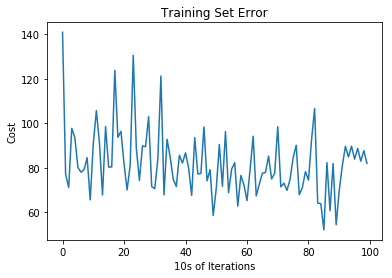

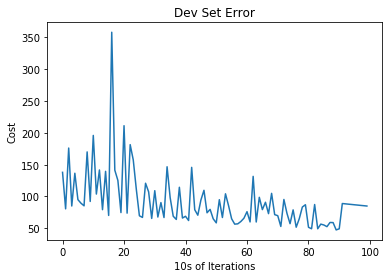

The train set error is: 84.7400586993
The dev set error is: 84.5610626843
The test set error is: 85.6333637419


In [30]:
hyperparameters["layers_units"] = [X.shape[0], 2048, 2048, 2048, 1024, 1024, 512, 512, 256, 128, 32, 1] 
parameters = run_model(TrainTestDevSets, hyperparameters)



It seems the larger model is learning slowly after a period where the error was fluctuating a lot, so rather than initialising the model with fresh parameters each time, it might be worth "babysitting" this model and further training the parameters. The **run_model** and **train_model** functions have now been adapted to pass in previous parameters as arguments to the model. 
Just in case the error suddenly spikes, and the model ends up performing worse a copy of the parameters has been saved.

Training the model, epoch: 1
Training cost after iteration 0: 86.7059289762
Dev set cost: 84.5103698667
Training cost after iteration 10: 81.0117732158
Dev set cost: 84.0051440275
Training the model, epoch: 2
Training cost after iteration 0: 85.7295046413
Dev set cost: 83.5517148811
Training cost after iteration 10: 80.0724871836
Dev set cost: 83.0499059553
Training the model, epoch: 3
Training cost after iteration 0: 84.7595745116
Dev set cost: 82.5995538987
Training cost after iteration 10: 79.1396949432
Dev set cost: 82.1011618584
Training the model, epoch: 4
Training cost after iteration 0: 83.7961342593
Dev set cost: 81.6538826677
Training cost after iteration 10: 78.2133923259
Dev set cost: 81.1589074999
Training the model, epoch: 5
Training cost after iteration 0: 82.839185996
Dev set cost: 80.714703258
Training cost after iteration 10: 77.2935813558
Dev set cost: 80.2231449418
Training the model, epoch: 6
Training cost after iteration 0: 81.8887296816
Dev set cost: 79.782015626

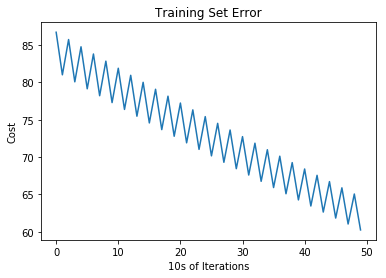

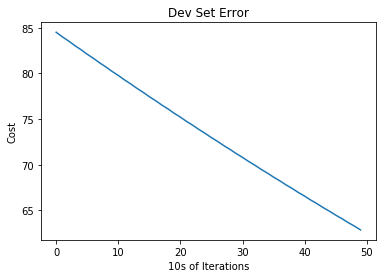

The train set error is: 62.7148998666
The dev set error is: 62.5336845903
The test set error is: 63.5261994276


In [38]:
prev_parameters = copy.deepcopy(parameters)
hyperparameters["num_epochs"] = 25
parameters = run_model(TrainTestDevSets, hyperparameters, parameters)


The training set error has steadily decreased while oscillating, while the dev set error has decreased in a straight line of constant gradient, suggesting that the model could decrease the error much more given more training.

Training the model, epoch: 1
Training cost after iteration 0: 64.2429134243
Dev set cost: 62.4915309446
Training cost after iteration 10: 59.4770989788
Dev set cost: 62.0717208518
Training the model, epoch: 2
Training cost after iteration 0: 63.4287776599
Dev set cost: 61.6951595139
Training cost after iteration 10: 58.7000913185
Dev set cost: 61.2787657285
Training the model, epoch: 3
Training cost after iteration 0: 62.6211322701
Dev set cost: 60.905278219
Training cost after iteration 10: 57.9295735486
Dev set cost: 60.4923007141
Training the model, epoch: 4
Training cost after iteration 0: 61.8199777291
Dev set cost: 60.1218875175
Training cost after iteration 10: 57.1655461094
Dev set cost: 59.7123262635
Training the model, epoch: 5
Training cost after iteration 0: 61.0253139799
Dev set cost: 59.3449873477
Training cost after iteration 10: 56.4080089338
Dev set cost: 58.9388423146
Training the model, epoch: 6
Training cost after iteration 0: 60.2371409648
Dev set cost: 58.57457764

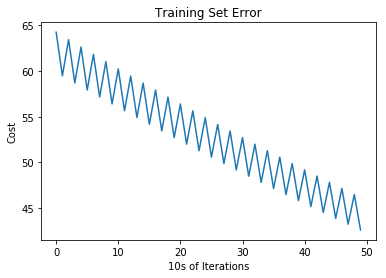

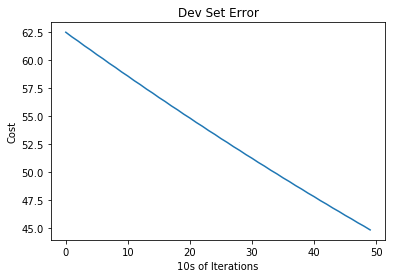

The train set error is: 44.7463255
The dev set error is: 44.5628917438
The test set error is: 45.4756484479


In [39]:
prev_parameters = copy.deepcopy(parameters)
hyperparameters["num_epochs"] = 25
parameters = run_model(TrainTestDevSets, hyperparameters, parameters)

The model has continued to learn, while the oscillations of the training cost have slightly decreased - this could be due to the Adam optimiser damping the oscillations of the weight updates in the directions that increase the error. Since the model has continued to train with the dev set error being a line of constant gradient, it might be worth doubling the learning rate to speed up the learning. 

Training the model, epoch: 1
Training cost after iteration 0: 45.8366364777
Dev set cost: 44.4956747839
Training cost after iteration 10: 41.6746606174
Dev set cost: 43.8291620857
Training the model, epoch: 2
Training cost after iteration 0: 44.540110054
Dev set cost: 43.2353219586
Training cost after iteration 10: 40.4591392864
Dev set cost: 42.5824627941
Training the model, epoch: 3
Training cost after iteration 0: 43.2695250548
Dev set cost: 42.0009083232
Training cost after iteration 10: 39.2695546086
Dev set cost: 41.3617021549
Training the model, epoch: 4
Training cost after iteration 0: 42.0248804605
Dev set cost: 40.7924327472
Training cost after iteration 10: 38.1059053308
Dev set cost: 40.1668790154
Training the model, epoch: 5
Training cost after iteration 0: 40.8061752102
Dev set cost: 39.6098940506
Training cost after iteration 10: 36.9681901407
Dev set cost: 38.9979921718
Training the model, epoch: 6
Training cost after iteration 0: 39.6134081989
Dev set cost: 38.45329100

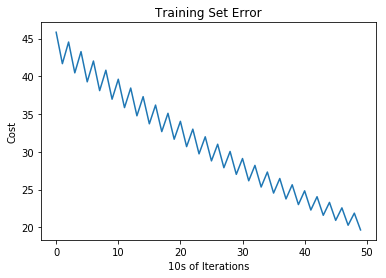

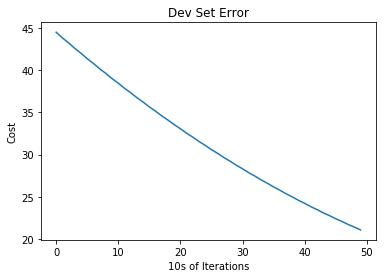

The train set error is: 20.9861264794
The dev set error is: 20.7982649671
The test set error is: 21.5518363004


In [40]:
prev_parameters = copy.deepcopy(parameters)
hyperparameters["learning_rate"] = 6e-3
parameters = run_model(TrainTestDevSets, hyperparameters, parameters)


The increase in learning rate has slightly sped up the converge, and the dev set and training set error graphs seem to be slightly levelling off, suggesting the local optima is close. It is worth doubling the learning rate again to see if this speeds up convergence.

Training the model, epoch: 1
Training cost after iteration 0: 21.2028482099
Dev set cost: 20.743066425
Training cost after iteration 10: 18.861707912
Dev set cost: 20.2058329996
Training the model, epoch: 2
Training cost after iteration 0: 20.1381589471
Dev set cost: 19.7398552958
Training cost after iteration 10: 17.9464434288
Dev set cost: 19.2404099047
Training the model, epoch: 3
Training cost after iteration 0: 19.145270553
Dev set cost: 18.8083990652
Training cost after iteration 10: 17.1028759249
Dev set cost: 18.3467257935
Training the model, epoch: 4
Training cost after iteration 0: 18.22415466
Dev set cost: 17.9486602892
Training cost after iteration 10: 16.3309565365
Dev set cost: 17.5247405567
Training the model, epoch: 5
Training cost after iteration 0: 17.3747786815
Dev set cost: 17.1605944777
Training cost after iteration 10: 15.6306257041
Dev set cost: 16.7744062738
Training the model, epoch: 6
Training cost after iteration 0: 16.5971048229
Dev set cost: 16.4441478531
T

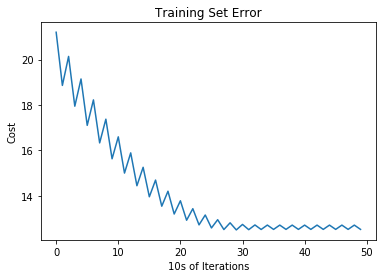

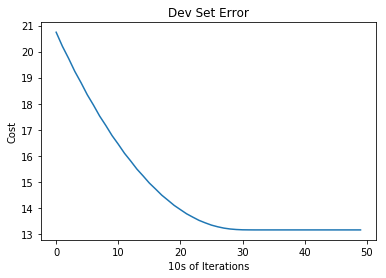

The train set error is: 13.3456314735
The dev set error is: 13.1534534462
The test set error is: 13.7518387151


In [41]:
prev_parameters = copy.deepcopy(parameters)
hyperparameters["learning_rate"] = 1e-2
parameters = run_model(TrainTestDevSets, hyperparameters, parameters)

Training the model, epoch: 1
Training cost after iteration 0: 12.7107116455
Dev set cost: 13.154546709
Training cost after iteration 10: 12.5200319318
Dev set cost: 13.1534724919
Training the model, epoch: 2
Training cost after iteration 0: 12.7181437101
Dev set cost: 13.1535468929
Training cost after iteration 10: 12.5193042053
Dev set cost: 13.1534790131
Training the model, epoch: 3
Training cost after iteration 0: 12.7157946442
Dev set cost: 13.1537362709
Training cost after iteration 10: 12.5194970476
Dev set cost: 13.1534780568
Training the model, epoch: 4
Training cost after iteration 0: 12.716503797
Dev set cost: 13.1536680623
Training cost after iteration 10: 12.5194358993
Dev set cost: 13.1534784361
Training the model, epoch: 5
Training cost after iteration 0: 12.7162866222
Dev set cost: 13.1536879034
Training cost after iteration 10: 12.5194543387
Dev set cost: 13.1534783288
Training the model, epoch: 6
Training cost after iteration 0: 12.7163528427
Dev set cost: 13.153681756

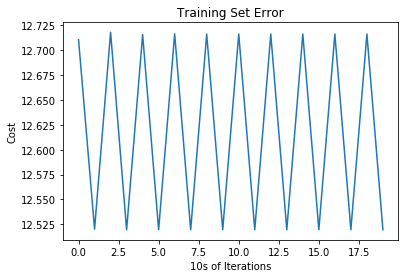

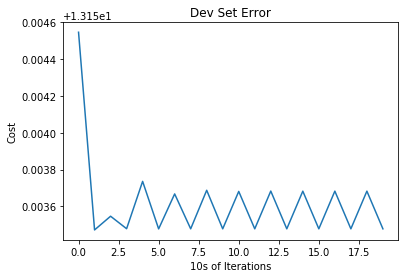

The train set error is: 13.3458038303
The dev set error is: 13.1536534429
The test set error is: 13.7530324133


In [42]:
prev_parameters = copy.deepcopy(parameters)
hyperparameters["learning_rate"] = 3e-2
hyperparameters["num_epochs"] = 10
parameters = run_model(TrainTestDevSets, hyperparameters, parameters)

While the training set error fluctuated a bit, the dev set cost remained mostly constant. Whilst the final train set error is greater than the dev set error, towards the end of training it was 12.5-12.7 - much less than the dev set error, suggesting the model is potentially overfitting or starting to overfit. Therefore, we will save the previous parameters separately in case this does turn out to be the case.

We could try to "bounce out" of the saddle point by tripling the learning rate and reducing the batch size to increase noise in the parameter updates - this experiment may result in a local optima with lower error rate and at worst it will result in the same error.

Training the model, epoch: 1
Training cost after iteration 0: 12.1851619486
Dev set cost: 13.1591426838
Training cost after iteration 10: 14.5199480915
Dev set cost: 13.1775099314
Training cost after iteration 20: 14.2854245038
Dev set cost: 13.1758708789
Training cost after iteration 30: 16.9507727393
Dev set cost: 13.2080074005
Training cost after iteration 40: 11.494452926
Dev set cost: 13.2233126467
Training cost after iteration 50: 12.4723674157
Dev set cost: 13.1559039157
Training cost after iteration 60: 10.1971653999
Dev set cost: 13.1653037593
Training cost after iteration 70: 17.0581882355
Dev set cost: 13.1568628383
Training cost after iteration 80: 14.0829338408
Dev set cost: 13.1540175762
Training cost after iteration 90: 16.4103981861
Dev set cost: 13.1572913347
Training cost after iteration 100: 13.7552441935
Dev set cost: 13.154622774
Training cost after iteration 110: 15.9138899056
Dev set cost: 13.1561940767
Training cost after iteration 120: 11.165265398
Dev set cost

Training cost after iteration 90: 16.4103185908
Dev set cost: 13.1572642589
Training cost after iteration 100: 13.755066468
Dev set cost: 13.1546006102
Training cost after iteration 110: 15.9141778886
Dev set cost: 13.156174243
Training cost after iteration 120: 11.1652656473
Dev set cost: 13.1617582979
Training cost after iteration 130: 13.8597099621
Dev set cost: 13.1892084311
Training cost after iteration 140: 18.3752420895
Dev set cost: 13.1608553893
Training cost after iteration 150: 15.2891742959
Dev set cost: 13.1589006375
Training the model, epoch: 8
Training cost after iteration 0: 12.1631319461
Dev set cost: 13.1834613717
Training cost after iteration 10: 14.5011174682
Dev set cost: 13.1677680669
Training cost after iteration 20: 14.2851881272
Dev set cost: 13.1766685614
Training cost after iteration 30: 16.9291047044
Dev set cost: 13.2020724132
Training cost after iteration 40: 11.4990867206
Dev set cost: 13.2216798443
Training cost after iteration 50: 12.4734818514
Dev set 

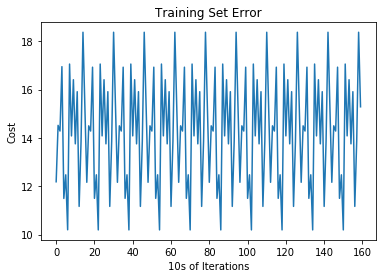

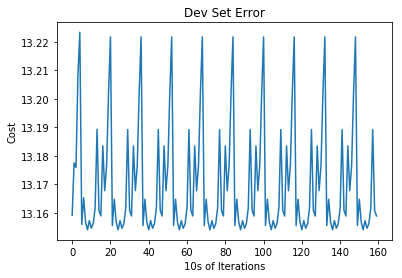

The train set error is: 13.3526778007
The dev set error is: 13.1603749677
The test set error is: 13.7542732583


In [43]:
good_parameters = copy.deepcopy(prev_parameters)
prev_parameters = copy.deepcopy(parameters)
hyperparameters["learning_rate"] = 9e-2
hyperparameters["batch_size"] = 64
parameters = run_model(TrainTestDevSets, hyperparameters, parameters)

Unfortunately, the increased noise did not result in a lower dev set error, so it appears we have definitely reached convergence, and we could now use the *good_parameters* as parameters in the model when we predict any future ground state energy values for molecules.


# Reflection:

To recap, with these parameters we achieved:

    Train set error: 13.3456314735
    
    Dev set error: 13.1534534462

    Test set error: 13.7518387151

Thus the unbiased mean square error the model achieved was *13.7518*, which corresponds to a root mean square error of **3.708**.

For comparison and as a baseline to evaluate this performance in context, the original research paper that this task was based used regression trees and a neural network (with a single layer). With the Coulomb matrix as input, the boosted regression tree obtained an root mean square error of **36.63** and the neural network a root mean square error of **58.39**.

The model trained has achieved a far better error than either of the machine learning methods trialled by the paper.
This model had 10 hidden layers, and had optimisation techniques such as batch-normalisation and Adam, and Dropout as a regularisation technique. 

To summarise, this model demonstrates the capabilities of deep neural networks, which vastly outperformed the traditional machine learning models previously used on this task.